# 6 Features
## Kernel Function 1: RBF + White
## Test Size = 0.4

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn import tree
from sklearn import neighbors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic


from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn import linear_model
from sklearn import ensemble 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.neighbors import KNeighborsRegressor


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
cwd = os.getcwd()

# Read and Scale the Data

In [3]:
train_data = pd.read_excel (r'training_fixed.xlsx')

name=['Z','N','A','A^2/3','(N-Z)/A','PF']

x_train = pd.DataFrame(train_data,  columns=name)  
y_train = pd.DataFrame(train_data, columns= ['MeV'])

test_size = 0.40  
random_state = 100 

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=random_state)

train_len=len(x_train)
test_len=len(x_test)

#test_data= pd.read_excel (r'test_fixed.xls')
#x_test = pd.DataFrame(test_data,  columns=name)  
#y_test = pd.DataFrame(test_data, columns= ['MeV'])

#test_len=len(x_test)

extra_data= pd.read_excel (r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data,  columns=name)  
y_extra = pd.DataFrame(extra_data, columns= ['MeV'])

inp=np.concatenate((x_train,x_test,x_extra),axis=0)
out=np.concatenate((y_train,y_test,y_extra),axis=0)
train_test_len=train_len+test_len
##################################
## scale
##################################
#sc_X= StandardScaler()
#inp = sc_X.fit_transform(inp)
#sc_Y = StandardScaler()
#out=sc_Y.fit_transform(out)

#x_train=inp[0:train_len]
#x_test=inp[train_len:train_test_len]
#x_extra=inp[train_test_len::]
#y_train=out[0:train_len]
#y_test=out[train_len:train_test_len]
#y_extra=out[train_test_len::]
# Splitting the data

x_train = inp[0:train_len]
x_test = inp[train_len:train_test_len]
x_extra = inp[train_test_len::]
y_train = out[0:train_len]
y_test = out[train_len:train_test_len]
y_extra = out[train_test_len::]

##################################
## scale
##################################
# Initialize the StandardScaler for input data
sc_X = StandardScaler()

# Fit the scaler on the training data
sc_X.fit(x_train)

# Transform the training and testing data using the fitted scaler
x_train = sc_X.transform(x_train)
x_test = sc_X.transform(x_test)
x_extra = sc_X.transform(x_extra)

# Initialize the StandardScaler for output data
sc_Y = StandardScaler()

# Fit the scaler on the training data
sc_Y.fit(y_train)

# Transform the training and testing data using the fitted scaler
y_train = sc_Y.transform(y_train)
y_test = sc_Y.transform(y_test)
y_extra = sc_Y.transform(y_extra)

# For input data
print("Input Data:")
print("Mean:", sc_X.mean_)
print("Standard Deviation:", sc_X.scale_)

# For output data
print("\nOutput Data:")
print("Mean:", sc_Y.mean_)
print("Standard Deviation:", sc_Y.scale_)
################################
name+=['original','prediction']


Input Data:
Mean: [ 57.57512229  80.21663173 137.79175402  25.98588518   0.15063681
   3.06218929]
Standard Deviation: [24.43648156 37.78841425 61.82343348  8.36100388  0.07366021  2.40608908]

Output Data:
Mean: [-40.35911008]
Standard Deviation: [42.23861824]


In [4]:
###################### Group 1 [(1e-2, 1e3),(1e-5, 1e1),1e-1 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-1] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-2, 1e3)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)
            

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9982914802470673
1.7459013656731388 2.0322123034952306 nan


In [5]:
###################### Group 2 [(1e-2, 1e3),(1e-5, 1e1),1e-5] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-5] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-2, 1e3)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995848233449978
0.8606491919741821 1.0761631354149876 nan


In [6]:
###################### Group 3 [(1e-2, 1e3),(1e-5, 1e1),1e-3] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-3] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-2, 1e3)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ######## 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9994372005635561
1.0020433945381575 1.1667630351448415 nan


In [7]:
###################### Group 4 [(1e-2, 1e3),(1e-10, 1e1),1e-1 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-1] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-2, 1e3)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9982917006726129
1.7457887378636054 2.032074366659531 nan


In [8]:
###################### Group 5 [(1e-2, 1e3),(1e-10, 1e1),1e-5 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-5] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-2, 1e3)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995848260627015
0.8606463751089554 1.0761614056581073 nan


In [9]:
###################### Group 6 [(1e-2, 1e3),(1e-10, 1e1),1e-3 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-3] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-2, 1e3)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9994391649462493
1.0002931108751927 1.1657063141777007 nan


In [10]:
###################### Group 7 [(1e-2, 1e3),(1e-5, 1e5),1e-1  ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-1] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-2, 1e3)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9982914802470673
1.7459013656731388 2.0322123034952306 nan


In [11]:
###################### Group 8 [(1e-2, 1e3),(1e-5, 1e5),1e-5  ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-5] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-2, 1e3)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995848233449978
0.8606491919741821 1.0761631354149876 nan


In [12]:
###################### Group 9 [(1e-2, 1e3),(1e-5, 1e5),1e-3  ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-3] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-2, 1e3)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9994372005635561
1.0020433945381575 1.1667630351448415 nan


In [13]:
###################### Group 10 [(1e-5, 1e5),(1e-5, 1e1),1e-1 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-1] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-5, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9982914785748732
1.7459022200633285 2.0322132635613515 nan


In [14]:
###################### Group 11 [(1e-5, 1e5),(1e-5, 1e1),1e-5 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-5] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-5, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995848258074935
0.8606466396292244 1.07616156737971 nan


In [15]:
###################### Group 12 [(1e-5, 1e5),(1e-5, 1e1),1e-3 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-3] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-5, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9994372005520024
1.0020434048236355 1.1667631572539887 nan


In [16]:
###################### Group 13 [(1e-5, 1e5),(1e-10, 1e1),1e-1] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-1] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-5, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9982920340275563
1.7456183942679642 2.0318346112340997 nan


In [17]:
###################### Group 14 [(1e-5, 1e5),(1e-10, 1e1),1e-5] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-5] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-5, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995848233862784
0.8606491491874007 1.0761631145677297 nan


In [18]:
###################### Group 15 [(1e-5, 1e5),(1e-10, 1e1),1e-3] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-3] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-5, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9994391022199015
1.000349047980854 1.1657332359528074 nan


In [19]:
###################### Group 16 [(1e-5, 1e5),(1e-5, 1e5),1e-1 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-1] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-5, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9982914785748732
1.7459022200633285 2.0322132635613515 nan


In [20]:
###################### Group 17 [(1e-5, 1e5),(1e-5, 1e5),1e-5 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-5] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-5, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995848258074935
0.8606466396292244 1.07616156737971 nan


In [21]:
###################### Group 18 [(1e-5, 1e5),(1e-5, 1e5),1e-3 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-3] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-5, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9994372005520024
1.0020434048236355 1.1667631572539887 nan


In [22]:
###################### Group 19 [(1e-6, 1e6),(1e-5, 1e1),1e-1] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-1] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-6, 1e6)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9982914786633477
1.7459021748582682 2.0322132281476866 nan


In [23]:
###################### Group 20 [(1e-6, 1e6),(1e-5, 1e1),1e-5] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-5] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-6, 1e6)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995848229768217
0.8606495735832295 1.0761634021429494 nan


In [24]:
###################### Group 21 [(1e-6, 1e6),(1e-5, 1e1),1e-3] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-3] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-6, 1e6)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9994372003984768
1.0020435414969153 1.1667631623700563 nan


In [25]:
###################### Group 22 [(1e-6, 1e6),(1e-10, 1e1),1e-1 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-1] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-6, 1e6)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.998291518495608
1.7458818228632995 2.0321866175630956 nan


In [26]:
###################### Group 23 [(1e-6, 1e6),(1e-10, 1e1),1e-5 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-5] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-6, 1e6)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995848251044759
0.8606473682986809 1.076162013581682 nan


In [27]:
###################### Group 24 [(1e-6, 1e6),(1e-10, 1e1),1e-3 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-3] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-6, 1e6)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9994391548457561
1.0003021183438816 1.1657122068530081 nan


In [28]:
###################### Group 25 [(1e-6, 1e6), (1e-5, 1e5),1e-1  ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-1] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-6, 1e6)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9982914786633477
1.7459021748582682 2.0322132281476866 nan


In [29]:
###################### Group 26 [(1e-6, 1e6), (1e-5, 1e5),1e-5  ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-5] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-6, 1e6)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995848229768217
0.8606495735832295 1.0761634021429494 nan


In [30]:
###################### Group 27 [(1e-6, 1e6), (1e-5, 1e5),1e-3 ] ######################  
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-3] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-6, 1e6)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9994372003984768
1.0020435414969153 1.1667631623700563 nan


# Plot

Column names: Index(['Z', 'N', 'A', 'A^2/3', '(N-Z)/A', 'PF', 'original', 'prediction',
       'Standard Deviation'],
      dtype='object')
Filtered data (Z=50):
       Z      N      A      A^2/3   (N-Z)/A            PF  original  \
2411  50   42.0   92.0  20.379423 -0.086957  4.440892e-16       NaN   
2412  50   43.0   93.0  20.526834 -0.075269  4.440892e-16       NaN   
2413  50   44.0   94.0  20.673717 -0.063830  4.440892e-16       NaN   
2414  50   45.0   95.0  20.820080 -0.052632  4.440892e-16       NaN   
2415  50   46.0   96.0  20.965931 -0.041667  4.440892e-16       NaN   
...   ..    ...    ...        ...       ...           ...       ...   
2493  50  124.0  174.0  31.167323  0.425287  4.440892e-16       NaN   
2494  50  125.0  175.0  31.286624  0.428571  4.440892e-16       NaN   
2495  50  126.0  176.0  31.405698  0.431818  4.440892e-16       NaN   
2496  50  127.0  177.0  31.524546  0.435028  4.440892e-16       NaN   
2497  50  128.0  178.0  31.643171  0.438202  4.440892e-16

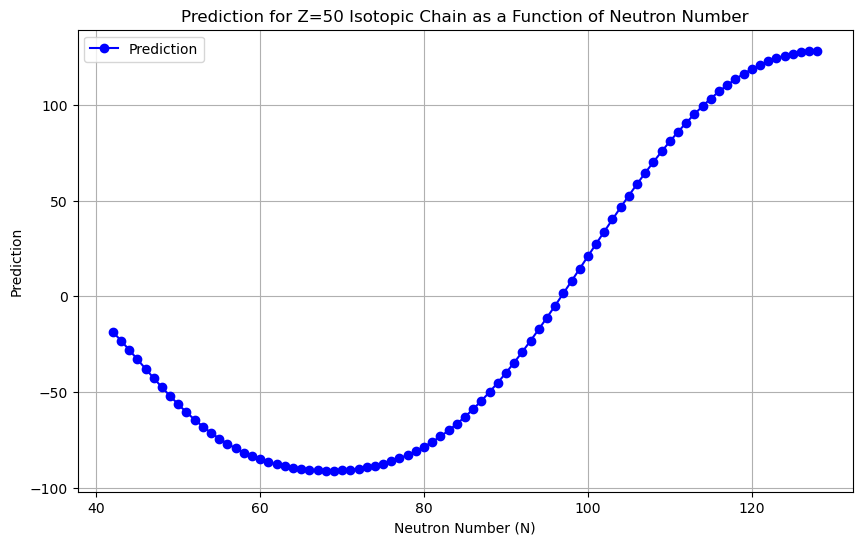

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'GP_Regression/extrapolation_with_std.xlsx'  # Update this with the actual path to your file
df = pd.read_excel(file_path)

# Check the column names to ensure they are correct
print("Column names:", df.columns)

# Filter the data for Z=50
df_Z50 = df[df['Z'] == 50]

# Check the filtered data
print("Filtered data (Z=50):")
print(df_Z50)

# Convert columns to numpy arrays before plotting
N_values = df_Z50['N'].values
prediction_values = df_Z50['prediction'].values

# Plot the prediction as a function of neutron number
plt.figure(figsize=(10, 6))
plt.plot(N_values, prediction_values, marker='o', linestyle='-', color='b', label='Prediction')

# Adding titles and labels
plt.title('Prediction for Z=50 Isotopic Chain as a Function of Neutron Number')
plt.xlabel('Neutron Number (N)')
plt.ylabel('Prediction')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

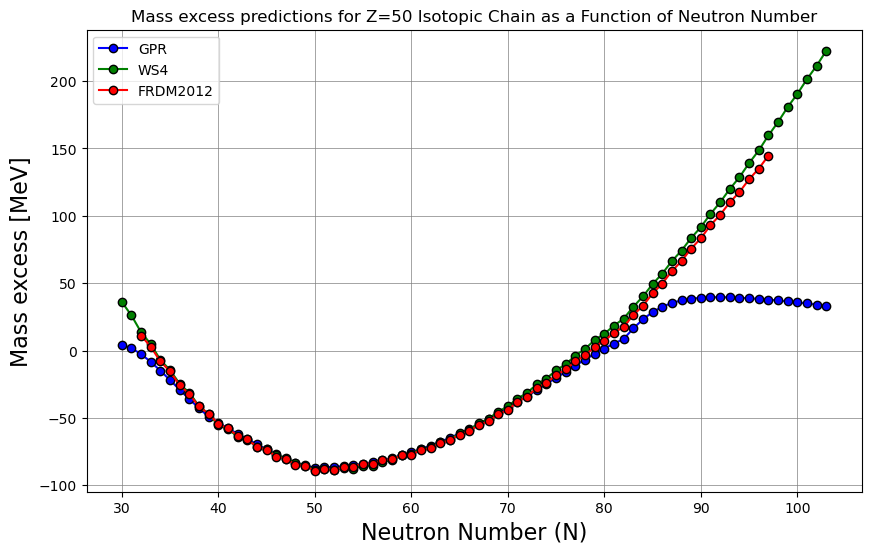

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_data(file_path, label, color):
    # Load the Excel file
    df = pd.read_excel(file_path)
    
    # Filter the data for Z=50
    df_Z50 = df[df['Z'] == 40]
    
    # Convert columns to numpy arrays before plotting
    N_values = df_Z50['N'].values
    prediction_values = df_Z50['prediction'].values
    
    # Plot the prediction as a function of neutron number
#    plt.plot(N_values, prediction_values, marker='o', linestyle='-', color=color, label=label)
     # Plot the prediction as a function of neutron number with black borders around the dots
    plt.plot(N_values, prediction_values, marker='o', linestyle='-', color=color, label=label, markerfacecolor=color, markeredgewidth=1, markeredgecolor='black')


# File paths for each dataset
file_paths = [
    'GP_Regression/extrapolation_with_std.xlsx',  
    'GP_Regression/WS4.xlsx',           
    'GP_Regression/FRDM2012.xlsx'        
]

# Labels and colors for each dataset
labels = ['GPR', 'WS4', 'FRDM2012']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'lime', 'pink', 'olive', 'brown', 'navy', 'teal', 'maroon']

# Plot each dataset
plt.figure(figsize=(10, 6))
for file_path, label, color in zip(file_paths, labels, colors):
    plot_data(file_path, label, color)

# Adding titles and labels
plt.title('Mass excess predictions for Z=50 Isotopic Chain as a Function of Neutron Number', fontsize=12)
plt.xlabel('Neutron Number (N)', fontsize=16)
plt.ylabel('Mass excess [MeV]', fontsize=16)
plt.legend()

# Remove background grid lines
plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5)


# Display the plot
plt.grid(True)
plt.show()

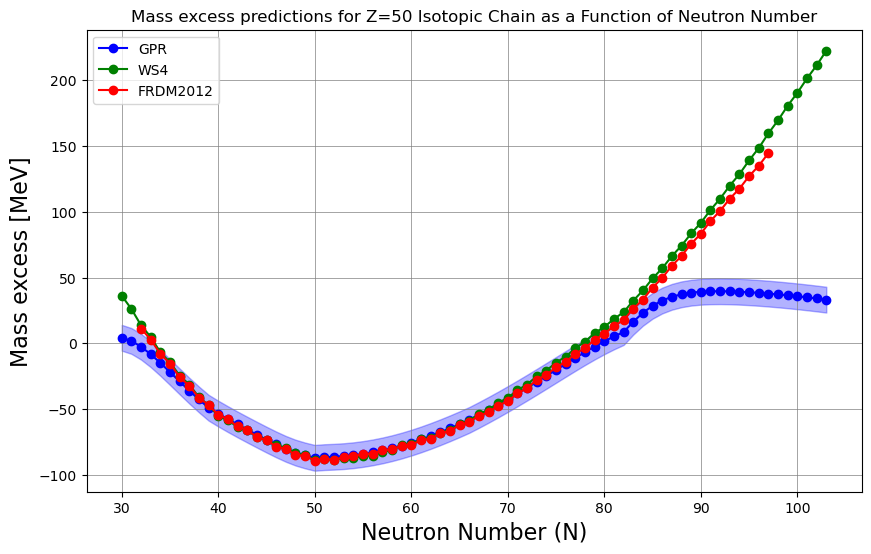

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_data_with_confidence_interval(file_path, label, color, plot_confidence=False):
    # Load the Excel file
    df = pd.read_excel(file_path)

    # Filter the data for Z=50
    df_Z50 = df[df['Z'] == 40]

    # Convert columns to numpy arrays before plotting
    N_values = df_Z50['N'].values
    prediction_values = df_Z50['prediction'].values

    if plot_confidence:
        # Check if the 'std' column exists
        if 'std' in df_Z50.columns:
            std_values = df_Z50['std'].values
        else:
            print(f"Warning: 'std' column not found in {file_path}. Using synthetic confidence intervals.")
            std_values = 5  # You can adjust this value based on your needs

        lower_bound = prediction_values - 1.96 * std_values
        upper_bound = prediction_values + 1.96 * std_values
        plt.fill_between(N_values, lower_bound, upper_bound, color=color, alpha=0.3)

    # Plot the prediction as a function of neutron number
    plt.plot(N_values, prediction_values, marker='o', linestyle='-', color=color, label=label)

# File paths for each dataset
file_paths = [
    'GP_Regression/extrapolation_with_std.xlsx',  # GPR with confidence intervals
    'GP_Regression/WS4.xlsx',
    'GP_Regression/FRDM2012.xlsx'
]

# Labels and colors for each dataset
labels = ['GPR', 'WS4', 'FRDM2012']
colors = ['b', 'g', 'r']

# Plot each dataset
plt.figure(figsize=(10, 6))
for file_path, label, color in zip(file_paths, labels, colors):
    if label == 'GPR':
        plot_data_with_confidence_interval(file_path, label, color, plot_confidence=True)
    else:
        plot_data_with_confidence_interval(file_path, label, color, plot_confidence=False)

# Adding titles and labels
plt.title('Mass excess predictions for Z=50 Isotopic Chain as a Function of Neutron Number')
plt.xlabel('Neutron Number (N)', fontsize=16)
plt.ylabel('Mass excess [MeV]', fontsize=16)
plt.legend()

# Remove background grid lines
plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5)

# Display the plot
plt.show()